# Use of Bayesian Optimisation in developmental robotics with Explauto

This tutorial explains and implements the use of Bayesian Optimisation for exploration algorithms used in developmental robotics. 
We use the [Explauto](https://github.com/flowersteam/explauto) Python library as a toolkit to help implement exploration algorithmes.

## Requirements:
- Python 2.7, Numpy, Scipy >= 0.16, Scikit-learn, [Jupyter](http://jupyter.readthedocs.io/en/latest/install.html). For users not familiar with Python, installing [Anaconda](https://www.continuum.io/downloads) for Python 2.7 includes all of them.
- [Explauto](https://github.com/flowersteam/explauto), the Python Library for Autonomous Exploration. See [installation](http://flowersteam.github.io/explauto/installation.html) section: the simplest is to install explauto via pip: 'pip install explauto'.
-  [GPy](https://github.com/SheffieldML/GPy), The Gaussian processes framework in Python and [GPyOpt](https://github.com/SheffieldML/GPyOpt) Gaussian process optimization using GPy.

Let's begin with the import of all the classes and functions we will need in this notebook.

In [1]:
import matplotlib
matplotlib.use('TkAgg')
import pickle
from utils import *
from explauto.sensorimotor_model.bayesian_optimisation import BayesianOptimisation
from explauto import Environment

# SimpleArm environment
First, we will use the SimpleArm environment using only angles to move the joints.

In [2]:
# Definition of the environment
environment = Environment.from_configuration('simple_arm', 'mid_dimensional')

Then you need to choose the interest model.

In [3]:
# Initialization of the interest model
im_model = InterestModel.from_configuration(environment.conf, environment.conf.s_dims, 'random')

For the sensorimotor model which use the Bayesian optimisation, you need to choose some parameters:

In [4]:
# The acquisition function for the optimisation, you can choose from LCB, MPI and EI.
acquisition = "LCB"
# The coefficient which do the trade-off between exploration and exploitation, 
# choose 0 for no exploration and 0.2 for a good trade off.
exploration_weight = 0.2
# Choose then number of initial points which initialize the optimisation, between 0 and 100.
k = 5
# Choose the number of iterations you want the optimisation doing,
# try not to exceed with the sum k plus the number of iterations.
optimisation_iterations = 20

params = {'acquisition':acquisition,
          'exploration_weight' : exploration_weight,
          'initial_points': k,
          'environment' : environment,
          'optimisation_iterations': optimisation_iterations,
          'exact_feval' : True}

sm_model = BayesianOptimisation(environment.conf, **params)

Iteration: 22
Measure of exploration: 4


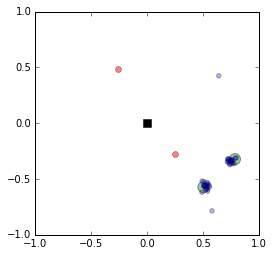

In [5]:
explored_s_agb = []
explorations = []

iterations = 40

%matplotlib inline
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim((-1, 1.))
ax.set_ylim((-1., 1.))
ax.plot(0., 0., 'sk', ms=8)

# Bootstrap model: 1 random motor babbling
m = environment.random_motors()[0]
s = environment.update(m)
sm_model.update(m,s)
s_goal = im_model.sample()

iteration = 0
while len(explorations) < iterations:
    iteration = len(explorations)
    if (iteration+1) % 1 == 0:
        clear_output(wait=True)
        print "Iteration:", iteration+1
    if random() < 0.2:
        # Do random motor babbling while the ball has not been grasped, and then in 20% of the trials
        m = environment.random_motors()[0]
        s = environment.update(m)
        sm_model.update(m, s)
    else:
        # Sample a sensory goal maximizing learning progress using the interest model:
        s_goal = im_model.sample()
        # Infer a motor command to reach that goal using the Nearest Neighbor algorithm:
        m = sm_model.inverse_prediction(tuple(s_goal))
        # Execute this command and observe the corresponding sensory effect:
        s = environment.update(m)
        # Update the sensorimotor model:
        sm_model.update(m, s)
        # Update the interest model:
        im_model.update(hstack((m, s_goal)), hstack((m, s)))
        # Update the exploration
        explorations.append(int(compute_explo(array(explored_s_agb), array([-1., -1.]), array([1., 1.]), gs=grid_size)))
        # Plot the goals in red:
        ax.plot([s_goal[0]], [s_goal[1]], 'or', alpha=0.5)
        explored_s_agb += [s] # store s for later evaluation
        # Plot the final sensori effect in green 
        ax.add_patch(Circle(tuple(s), 0.05, fc="g", alpha=0.4))
        # Do the treatment of the points explored during the optimisation
        S = []
        size = len( sm_model.dataset )
        for index in range(size - optimisation_iterations, size):
            S.append(sm_model.dataset.get_y(index- 1))
        for s in S:
            explored_s_agb += [s] # store s for later evaluation
            ax.add_patch(Circle(tuple(s), 0.02, fc="b", alpha=0.3))
            explorations.append(int(compute_explo(array(explored_s_agb), array([-1., -1.]), array([1., 1.]), gs=grid_size)))
        
explorations = explorations[:iterations]
exploration = explorations[-1]
print "Measure of exploration:", exploration

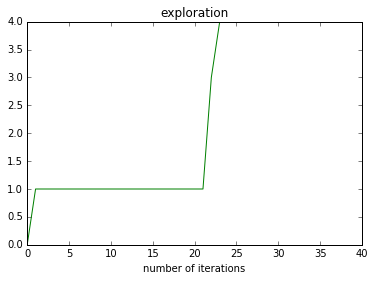

In [6]:
# Plot the exploration trough the learning
x  = [j for j in range(len(explorations))]
plt.plot(x, explorations,'g')
plt.xlabel("number of iterations")
plt.title("exploration")

If you want to measure the competence gained thanks to the learning, which correspond to the distance to the goal of multiple iterations of inference. 

{'boxes': [<matplotlib.lines.Line2D at 0x7f6b03ea2650>],
 'caps': [<matplotlib.lines.Line2D at 0x7f6b03f11190>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f6b03f72c10>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f6b03efb890>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f6b03e97f10>,
  <matplotlib.lines.Line2D at 0x7f6b03e8d710>]}

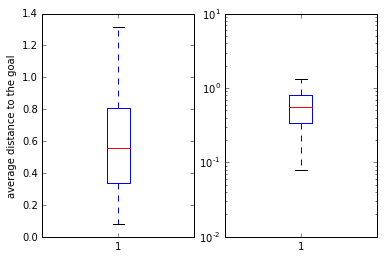

In [8]:
# Choose the models you want to test
competence = []

# Use the dataset of the learning 
dataset = sm_model.dataset

# To test with the basic model which is the nearest naighbor model
paramNN = "NN"

# To test the Bayesian optimisation
paramBO = {'acquisition': "LCB", 'exploration_weight' : 0, 'initial_points': 50,
    'environment' : environment, 'optimisation_iterations': 1, 'exact_feval' : True}

param = paramNN

# Number iterations of inference
j1 = 100

# Number of inferences
b = 20

competence.append(mesure_competence(dataset,param,environment,j, b))

plt.subplot(121)
plt.ylabel("average distance to the goal")
plt.boxplot(competence)

plt.subplot(122)
plt.yscale('log')
plt.boxplot(competence)

# ArmBall 

For second environment we can use the environment ArmBall which is a arm which can move a ball with its extremity. The joints use DMPs to move, so the extremity follows a trajectory.

In [9]:
import matplotlib
matplotlib.use('TkAgg')

from utils import *
from explauto.sensorimotor_model.bayesian_optimisation import BayesianOptimisation
import pickle
from explauto.environment import available_configurations
from explauto import Environment
from time import *

In [10]:
# Definition of the environment

n_joints = 7      # Number of joints
n_dmp_basis = 3   # Number of basis per joint
goal_size = 1.    # Size of the 2D goal space

environment = ArmBall(n_joints, n_dmp_basis, goal_size)

In [11]:
# Initialization of the interest model
im_model = InterestModel.from_configuration(environment.conf, environment.conf.s_dims, 'random')

In [12]:
# The acquisition function for the optimisation, you can choose from LCB, MPI and EI.
acquisition = "LCB"
# The coefficient which do the trade-off between exploration and exploitation, 
# choose 0 for no exploration and 0.2 for a good trade off.
exploration_weight = 0.2
# Choose then number of initial points which initialize the optimisation, between 0 and 100.
k = 5
# Choose the number of iterations you want the optimisation doing,
# try not to exceed with the sum k plus the number of iterations.
optimisation_iterations = 20

params = {'acquisition':acquisition,
          'exploration_weight' : exploration_weight,
          'initial_points': k,
          'environment' : environment,
          'optimisation_iterations': optimisation_iterations,
          'exact_feval' : True}

sm_model = BayesianOptimisation(environment.conf, **params)

Iteration: 19


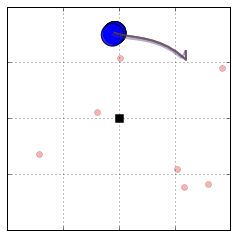

Number of ball catch: 22
Measure of exploration: 2
Time

NameError: name 'TimeAll' is not defined

In [15]:
explored_s_agb = []
explorations = []
number_balls_catched = []

iterations = 2

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim((-1, 1.))
ax.set_ylim((-1., 1.))
ax.plot(0., 0., 'sk', ms=8)


# Bootstrap model: 1 random motor babbling
m = environment.random_motors()[0]
s = environment.update(m)
sm_model.update(m,s)

s_goal = im_model.sample()

iteration = 0

while iteration < iterations:
    iteration = len(explorations)
    if (iteration+1) % 1 == 0:
        clear_output(wait=True)
        print "Iteration:", iteration+1
    if random() < 0.2:
        # Do random motor babbling while the ball has not been grasped, and then in 20% of the trials
        m = environment.random_motors()[0]
        s = environment.update(m)
        sm_model.update(m, s)
        if abs(s[-1] - 0.6) > 0.001 : # if the ball has been moved by the arm, we plot its trajectory and last position
            explored_s_agb += [s] # store s for later evaluation
            ax.plot(environment.s_traj[:,0], environment.s_traj[:,1], lw=2, alpha=0.1)
            ax.add_patch(Circle(tuple(environment.s_traj[-1,:]), 0.1, fc="b", alpha=0.3))

        explorations.append(int(compute_explo(array(explored_s_agb), array([-1., -1.]), array([1., 1.]), gs=grid_size)))
        number_balls_catched.append(len(explored_s_agb))
    else:
        # Sample a sensory goal maximizing learning progress using the interest model:
        s_goal = im_model.sample()
        # Infer a motor command to reach that goal using the Nearest Neighbor algorithm:
        m = sm_model.inverse_prediction(tuple(s_goal))
        # Execute this command and observe the corresponding sensory effect:
        s = environment.update(m)
        # Update the sensorimotor model:
        sm_model.update(m, s)
        # Update the interest model:
        im_model.update(hstack((m, s_goal)), hstack((m, s)))
        # Plot the goals in red:
        ax.plot([s_goal[0]], [s_goal[1]], 'or', alpha=0.3)

        S = []
        size = len( sm_model.dataset )
        for index in range(size - optimisation_iterations, size):
            S.append(sm_model.dataset.get_y(index-1))
        for s in S:
            if abs(s[-1] - 0.6) > 0.001: # if the ball has been moved by the arm, we plot its trajectory and last position
                explored_s_agb += [s] # store s for later evaluation
                explorations.append(int(compute_explo(array(explored_s_agb), array([-1., -1.]), array([1., 1.]), gs=grid_size)))
                number_balls_catched.append(len(explored_s_agb))
                ax.plot(environment.s_traj[:,0], environment.s_traj[:,1], lw=2, alpha=0.1)
                ax.add_patch(Circle(tuple(environment.s_traj[-1,:]), 0.1, fc="b", alpha=0.3))



explorations = explorations[:iterations]
number_balls_catched = number_balls_catched[:iterations]


plt.xticks(linspace(-1., 1., 5))
plt.yticks(linspace(-1., 1., 5))
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.grid()
plt.ioff()
plt.show()

Nb_balls = len(explored_s_agb)
exploration = int(compute_explo(array(explored_s_agb), array([-1., -1.]), array([1., 1.]), gs=grid_size))
print "Number of ball catch:", Nb_balls
print "Measure of exploration:", exploration

{'boxes': [<matplotlib.lines.Line2D at 0x7f6b0397a710>],
 'caps': [<matplotlib.lines.Line2D at 0x7f6b03985810>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f6b03990b10>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f6b039904d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f6b0397aad0>,
  <matplotlib.lines.Line2D at 0x7f6b039851d0>]}

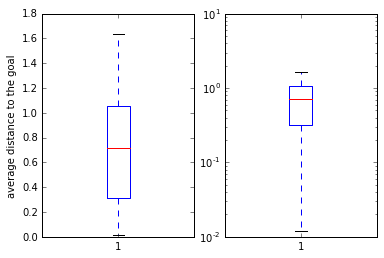

In [16]:
''' Choose the models you want to test '''
competence = []

# Use the dataset of the learning 
dataset = sm_model.dataset

# To test with the basic model which is the nearest naighbor model
paramNN = "NN"

# To test the Bayesian optimisation
paramBO = {'acquisition': "LCB", 'exploration_weight' : 0, 'initial_points': 50,
    'environment' : environment, 'optimisation_iterations': 1, 'exact_feval' : True}

param = paramNN

# Number iterations of inference
j1 = 100

# Number of inferences
b = 20

competence.append(mesure_competence(dataset,param,environment,j, b))

plt.subplot(121)
plt.ylabel("average distance to the goal")
plt.boxplot(competence)

plt.subplot(122)
plt.yscale('log')
plt.boxplot(competence)